In [1]:
import requests
import json
import pandas as pd
from pprint import pprint
import psycopg2
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# add user_query input and use the keyword to creat the api query
user_query = input('Enter your news query keyword: ')
url = ('https://newsapi.org/v2/everything?'
       f"q={user_query}&"
       'language=en&'
       'apiKey=793b823d0dc04f2a9b1a1e0d0c025150')


response = requests.get(url)
print(response)

Enter your news query keyword: apple
<Response [200]>


In [3]:
user_news = response.json()

In [4]:
user_news['articles']
news_data = user_news['articles']

In [5]:
structured_data = []

for news in news_data:
    data ={
      'url':news['url'],
      'title':news['title'],
      'description':news['description'],
      'content':news['content']
    }
    structured_data.append(data)




In [6]:
def clean_text(text):
      if text is not None:
        text = text.lower()
        words = text.split()
        stop_words = set(['a', 'has', 'an', 'the', 'are', 'and', 'of', 'as', 'its', 'be', 'in', 'like', 'that', 'this', 'no', 'yes', 'on', 'at', 'for', 'because', 'though', 'to', 'with', 'by', 'he', 'his', 'i', 'you', 'she', 'it', 'we', 'they', 'from', 'about', 'have', 'is', 'will', 'was', 'were', 'been', 'has', 'have', 'having', 'do', 'does', 'did', 'doing', 'up', 'down', 'in', 'out', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'too', 'very', 'just', 'don', 'should', 'now', 'd', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'])
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
      return ''

In [7]:
user_news_data = []

for x in structured_data:
    content = x.get('content', '')
    description = x.get('description', '')
    title = x.get('title', '')
    url = x.get('url', '')

    clean_content = clean_text(content)
    clean_description = clean_text(description)
    clean_title = clean_text(title)

    clean_news ={
      'url': url,
      'title': clean_title,
      'description': clean_description,
      'content': clean_content
    }
    user_news_data.append(clean_news)


In [8]:
connection = psycopg2.connect(
   host = 'data-sandbox.c1tykfvfhpit.eu-west-2.rds.amazonaws.com',
   database = 'pagila',
   options='-c search_path=student',
   user = 'de8_sism39',
   password = 'XXnuz75.',
   port = "5432"
)

In [9]:
# create table, but with the addition of DuplicateTable error exception if the query has already been made
cur = connection.cursor()

create_table_query = f"""
    CREATE TABLE {user_query} (
      id SERIAL PRIMARY KEY,
      title TEXT,
      description TEXT,
      content TEXT,
      url TEXT UNIQUE
    );
  """
try:
  cur.execute(create_table_query)
except psycopg2.errors.DuplicateTable:
   print(f"Table '{user_query}' already exists. Skipping table creation.")
connection.commit()


Table 'apple' already exists. Skipping table creation.


In [10]:
insert_data = [(x['title'], x['description'], x['content'], x['url'])
    for x in user_news_data
]

insert_query = f'INSERT INTO {user_query} (title, description, content, url) VALUES (%s, %s, %s, %s)'
insert_count = 0

for data in insert_data:
    existing_query = f'SELECT 1 FROM {user_query} WHERE url = %s'
    cur.execute(existing_query, (data[3],))
    if not cur.fetchone():
        cur.execute(insert_query, data)
        insert_count +=1
if insert_count == 0:
    print('No new data inserted.')
else:
    print (f'Inserted {insert_count} new entries.')
connection.commit()

Inserted 16 new entries.


In [11]:
# save as a csv file inorder to use with matplotlib
user_table = user_query
csv_user = f'{user_query}.csv'
query = f'COPY {user_table} TO STDOUT WITH CSV HEADER'
with open(csv_user, 'w') as file:
  cur.copy_expert(query, file)


In [12]:
# had to add the path because content could not be located without??
csv_file_path = f'/content/{user_query}.csv'
df = pd.read_csv(csv_file_path)

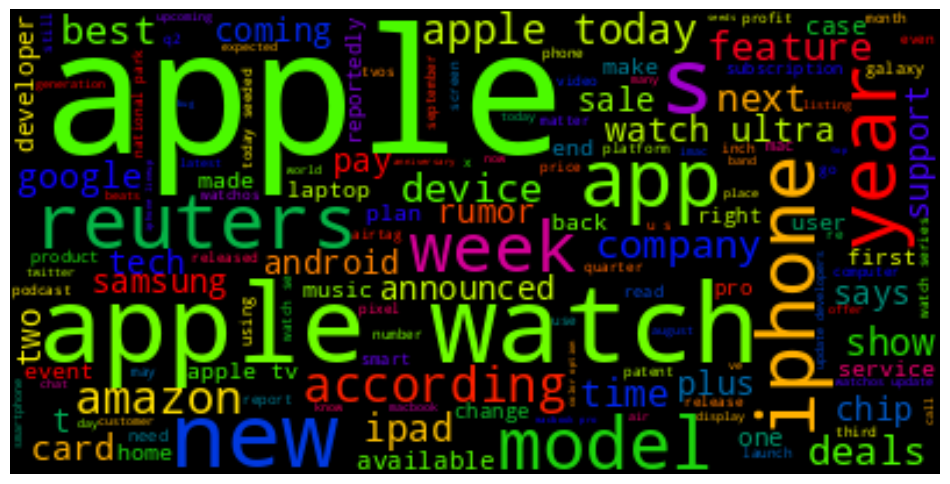

In [13]:
cloud_text = (df['title'] + ' ' + df['description']).str.cat(sep=' ')

plt.rcParams['figure.figsize'] = (12,12)
wordcloud = WordCloud(max_font_size =75, max_words=150, background_color= 'black', colormap='prism').generate(cloud_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()